# Segmented RF

In [ ]:
library(dplyr)
library(data.table)
library(partykit)
library(tictoc)
library(caret)
library(e1071)
library(randomForest)
library(ranger)

#for 3d plotting
library(akima)
library(plotly)

# for prep data
library(rPython)
library(stringr)
library(pbapply)
library(stringdist)
library(data.table)

getwd()

In [ ]:

source('../orig/functions.R')

source('../orig/functions_models.R')

source('functions_eval.R')
# 
# source('load_prep_data_expiry.R')


# Identify major registrar with poor performance for head to head

In [3]:
joint_pred_df <- read.csv("../../data/joint_pred_df.csv")
head(joint_pred_df)

,reg,obs_count_s,na_count_s,TP_s,TN_s,P_s,N_s,acc_0.5_s,tpr_0.5_s,tnr_0.5_s,⋯,N_r,acc_0.5_r,tpr_0.5_r,tnr_0.5_r,fpr_0.5_r,fnr_0.5_r,auc_r,aucpr_r,aucpr_srrat,acc_srrat
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1&1 internet,2321,6,460,863,1000,1315,0.5714903,0.46000000,0.6562738,⋯,1318,0.5691512,0.23030907,0.8270106,0.17298938,0.7696909,0.5654244,0.4847203,1.0043963,1.0041097
2,101 domain,32,6,14,6,16,10,0.7692308,0.87500000,0.6000000,⋯,13,0.6562500,1.00000000,0.1538462,0.84615385,0.0000000,0.6923077,0.8021654,0.8717474,1.1721612
3,10dencehispahard,165,2,2,128,31,132,0.7975460,0.06451613,0.9696970,⋯,134,0.8060606,0.03225806,0.9850746,0.01492537,0.9677419,0.7087145,0.3286169,1.0619508,0.9894368
4,1api,190,8,56,45,79,103,0.5549451,0.70886076,0.4368932,⋯,106,0.4789474,0.25000000,0.6603774,0.33962264,0.7500000,0.4977538,0.4620861,1.0168691,1.1586765
5,22net inc,51,0,2,49,2,49,1.0000000,1.00000000,1.0000000,⋯,49,1.0000000,1.00000000,1.0000000,0.00000000,0.0000000,1.0000000,1.0000000,1.0000000,1.0000000
6,ab name isp,15,3,7,0,7,5,0.5833333,1.00000000,0.0000000,⋯,6,0.5333333,0.77777778,0.1666667,0.83333333,0.2222222,0.3888889,0.5754147,1.2661675,1.0937500


In [5]:
# by accuracy
joint_pred_df[c("reg","obs_count_s","na_count_s","acc_0.5_s","acc_0.5_r","acc_srrat")] %>% arrange(desc(obs_count_s))

reg,obs_count_s,na_count_s,acc_0.5_s,acc_0.5_r,acc_srrat
<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>
namecheap,55117,0,0.9392746,0.9386578,1.0006572
gmo,31494,8,0.9569015,0.9577380,0.9991266
alibaba,30567,1,0.9654191,0.9656492,0.9997617
go daddy,27537,0,0.8560482,0.8553946,1.0007642
pdr ltd,16402,473,0.8698600,0.8735520,0.9957736
reg.ru,15373,1,0.9514702,0.9514083,1.0000651
chengdu west,14040,1,0.9749270,0.9745726,1.0003636
gandi sas,11686,2,0.9649093,0.9655143,0.9993734
hostinger,11140,0,0.9300718,0.9300718,1.0000000


In [9]:
# by auc
joint_pred_df[c("reg","obs_count_s","na_count_s","tpr_0.5_s","tpr_0.5_r","aucpr_s","aucpr_r","aucpr_srrat")] %>% arrange(desc(obs_count_s))

reg,obs_count_s,na_count_s,tpr_0.5_s,tpr_0.5_r,aucpr_s,aucpr_r,aucpr_srrat
<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
namecheap,55117,0,0.006009615,0.063401442,0.20315002,0.18892813,1.0752767
gmo,31494,8,0.141703377,0.030036630,0.38607414,0.11609370,3.3255390
alibaba,30567,1,0.001913876,0.003827751,0.16570439,0.17257293,0.9601992
go daddy,27537,0,0.095415118,0.065923172,0.35813266,0.33671268,1.0636150
pdr ltd,16402,473,0.153734940,0.017274472,0.40277116,0.27120713,1.4851053
reg.ru,15373,1,0.001340483,0.000000000,0.18745978,0.14659013,1.2788022
chengdu west,14040,1,0.022471910,0.011204482,0.27039679,0.22024362,1.2277168
gandi sas,11686,2,0.060975610,0.051094891,0.33287310,0.34864064,0.9547742
hostinger,11140,0,0.000000000,0.000000000,0.10372553,0.08330299,1.2451598


# Rf for one registrar of choice

In [3]:
reg_name = 'gmo'

# subset data

dim(expiry_train_df_sub)
dim(expiry_test_df_sub)
cat('\n')

expiry_train_df_sub_reg <- expiry_train_df_sub %>% filter(registrar==reg_name)
expiry_test_df_sub_reg <- expiry_test_df_sub %>% filter(registrar==reg_name)


dim(expiry_train_df_sub_reg)
dim(expiry_test_df_sub_reg)
cat('\n')


dim(expiry_train_df_sub_reg)/dim(expiry_train_df_sub)
dim(expiry_test_df_sub_reg)/dim(expiry_test_df_sub)

[1] 1188250      12

[1] 296797     12

[1] 126254     12

[1] 31494    12

[1] 0.1062521 1.0000000

[1] 0.1061129 1.0000000

In [4]:
# train & test RF


ranger_03_reg <- ranger(
    formula         = renewal_status ~ ., 
    data            = expiry_train_df_sub_reg, 
    importance = 'impurity', 
    num.trees       = 1000,
    probability = TRUE,
    mtry            = 3,
    min.node.size   = 10,
    replace = FALSE,
    sample.fraction = .8,
    seed            = 123
)

ranger_predict_03_reg <- predict(ranger_03_reg, 
                          data = expiry_test_df_sub_reg,
                          type="response")$predictions

ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed

ranger_03_pred_df_reg = data.frame("actual" = expiry_test_df_sub_reg$renewal_status,
          "predicted" = ranger_predict_03_reg)

lift_df_ranger_03_reg <- chart_lift(pred_df = ranger_03_pred_df_reg,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_ranger_03_reg <- plot_gains (lift_df_ranger_03_reg) 

auc_ranger_03_reg <- calc_auc(lift_df_ranger_03_reg)
toc()







# save(ranger_03_reg, file="../../data/output/ranger_03_reg")
# save(ranger_predict_03_reg, 
#      file="../../data/output/ranger_predict_03_reg")
# saveRDS(lift_df_ranger_03_reg, file.path('../../data/output/',"lift_df_ranger_03_reg"))



In [5]:
auc_ranger_03_reg

[1] 0.760696

# Seg_GLM for one registrar of choice

In [6]:
filename = 'seg_glm_expiry_exptest'
system(paste(sprintf("gsutil cp gs://data_input/%s /home/jupyter/local/Domains_202003/data/", filename)))
seg_glm_expiry_exptest <- readRDS(file.path("/home/jupyter/local/Domains_202003/data/", filename))

In [7]:
reg_name = 'gmo'

# subset data

dim(seg_glm_expiry_exptest)
cat('\n')

seg_glm_expiry_exptest_reg <-seg_glm_expiry_exptest %>% filter(registrar==reg_name)


dim(seg_glm_expiry_exptest_reg)
cat('\n')


dim(seg_glm_expiry_exptest_reg)/dim(seg_glm_expiry_exptest)



[1] 296797     40

[1] 31494    40

[1] 0.1061129 1.0000000

In [8]:
seg_glm_expiry_exptest_pred_df_reg = data.frame("actual" = seg_glm_expiry_exptest_reg$renewal_status,
          "predicted" = seg_glm_expiry_exptest_reg$first_renewal_prediction)

lift_df_seg_glm_expiry_exptest_reg <- chart_lift(pred_df = seg_glm_expiry_exptest_pred_df_reg,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_seg_glm_expiry_exptest_reg <- plot_gains (lift_df_seg_glm_expiry_exptest_reg) 

auc_seg_glm_expiry_exptest_reg<- calc_auc(lift_df_seg_glm_expiry_exptest_reg)


# saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

In [9]:
auc_seg_glm_expiry_exptest_reg

[1] 0.8876557

In [10]:
prop.table(table(seg_glm_expiry_exptest_reg$renewal_status))


   Renewed Not Renewd 
0.04334159 0.95665841 

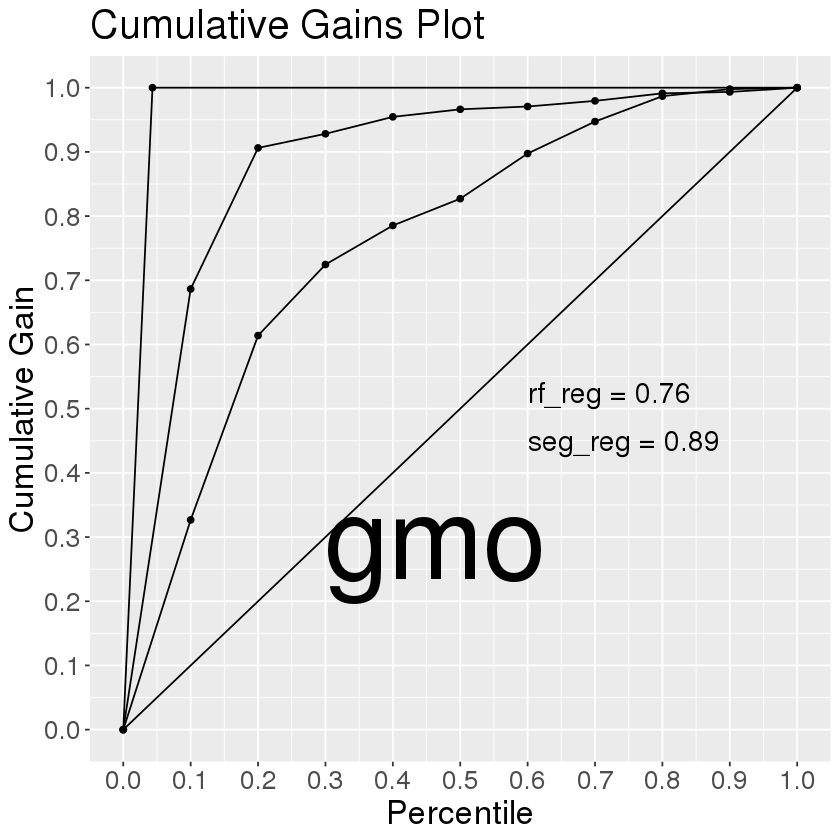

In [12]:
plot_multigains_reg <- plot_multigains(
    lift_df_list=list(
        rf_reg = lift_df_ranger_03_reg,
        seg_reg = lift_df_seg_glm_expiry_exptest_reg),
    auc_list = list(
        rf_reg= calc_auc(lift_df_ranger_03_reg),
        seg_reg= calc_auc(lift_df_seg_glm_expiry_exptest_reg)),
    prop_positive = 0.04334159)
# png(file = "../../data/output/plot_multigains_03_summ4.png",
#     width = 500, height = 375)
plot(plot_multigains_reg + 
      annotate("text", x = .3, y = .3, hjust = 0, label=reg_name, size = 24))
# dev.off()

# Train GLM from "scratch"

In [17]:
reg_name

[1] "gmo"

In [30]:
grep(reg_name, names(expiry_train_prepped_2), value=TRUE)

[1] "fungmo"     "hostgmo"    "in.netgmo"  "onlinegmo"  "pressgmo"  
 [6] "pwgmo"      "sitegmo"    "spacegmo"   "storegmo"   "techgmo"   
[11] "websitegmo"

In [34]:
train_df <- rbindlist(expiry_train_prepped_2[grep(reg_name, names(expiry_train_prepped_2), value=TRUE)],use.names=TRUE)
dim(train_df)

[1] 115069     39

In [35]:
unique(train_df$registrar)

[1] "gmo"

In [37]:
model_reg <- build_model_first_renewal_reg(train_df)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


In [38]:
summary(model_reg)


Call:
glm(formula = renewal_status ~ ., family = binomial(link = "logit"), 
    data = build_data, model = FALSE, y = FALSE)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2880  -0.2497  -0.0914  -0.0042   5.6456  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -4.158e-01  2.125e-01  -1.957 0.050346 .  
pattern_domain_count -5.289e-01  4.001e-02 -13.219  < 2e-16 ***
log_reg_arpt          2.293e-01  7.309e-02   3.138 0.001703 ** 
sld_length            2.055e-02  5.045e-03   4.073 4.65e-05 ***
sld_typehyphen-ln    -2.900e+00  2.308e-01 -12.561  < 2e-16 ***
sld_typel            -1.335e+00  5.249e-02 -25.436  < 2e-16 ***
sld_typeln           -2.433e+00  8.296e-02 -29.324  < 2e-16 ***
sld_typen            -5.742e+00  5.147e-01 -11.156  < 2e-16 ***
sld_typeidn          -6.722e-01  1.134e-01  -5.930 3.03e-09 ***
day_domains          -6.708e-04  2.315e-05 -28.970  < 2e-16 ***
gibb_score            4.828e-02  2.608e-0

In [40]:
test_df <- rbindlist(expiry_test_prepped_2[grep(reg_name, names(expiry_test_prepped_2), value=TRUE)],use.names=TRUE)
dim(test_df)

[1] 28576    39

In [45]:
head(test_df)

renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,reseller,⋯,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count
<chr>,<int>,<date>,<int>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,⋯,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>
FirstTime,1,2020-04-25,47208612,uranai.fun,2017-04-25,Active,fun,gmo,gmo,⋯,l,6,6l,1,2.457021,7.88,uranai,1,1,1
FirstTime,1,2020-01-15,59495443,tea-time.fun,2018-01-15,Active,fun,gmo,gmo,⋯,hyphen-l,8,8hyphen-l,1,2.110213,9.25,tea-time,1,1,1
FirstTime,1,2020-02-12,60982952,movie-mania.fun,2018-02-12,Active,fun,gmo,gmo,⋯,hyphen-l,11,11hyphen-l,1,2.079442,6.38,movie-mania,1,1,1
FirstTime,1,2020-02-24,61743467,good-luck.fun,2018-02-24,Active,fun,gmo,gmo,⋯,hyphen-l,9,9hyphen-l,1,2.079442,2.65,good-luck,1,1,1
FirstTime,1,2020-03-07,62380617,mojomojo.fun,2018-03-07,Active,fun,gmo,gmo,⋯,l,8,8l,1,2.079442,3.41,mojomojo,1,1,1
FirstTime,1,2020-03-10,63096237,myao.fun,2018-03-10,Active,fun,gmo,gmo,⋯,l,4,4l,1,2.079442,0.61,myao,1,1,1


In [58]:
pred_reg <- predict_first_renewal_reg(test_df, model_reg)

In [59]:
head(pred_reg)

renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,reseller,⋯,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count,probabilities,first_renewal_prediction
<chr>,<int>,<date>,<int>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,⋯,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>
FirstTime,1,2020-04-25,47208612,uranai.fun,2017-04-25,Active,fun,gmo,gmo,⋯,6l,1,2.457021,7.88,uranai,1,1,1,0.6442021,0.644
FirstTime,1,2020-01-15,59495443,tea-time.fun,2018-01-15,Active,fun,gmo,gmo,⋯,8hyphen-l,1,2.110213,9.25,tea-time,1,1,1,0.7948046,0.795
FirstTime,1,2020-02-12,60982952,movie-mania.fun,2018-02-12,Active,fun,gmo,gmo,⋯,11hyphen-l,1,2.079442,6.38,movie-mania,1,1,1,0.7807682,0.781
FirstTime,1,2020-02-24,61743467,good-luck.fun,2018-02-24,Active,fun,gmo,gmo,⋯,9hyphen-l,1,2.079442,2.65,good-luck,1,1,1,0.7405752,0.741
FirstTime,1,2020-03-07,62380617,mojomojo.fun,2018-03-07,Active,fun,gmo,gmo,⋯,8l,1,2.079442,3.41,mojomojo,1,1,1,0.4329139,0.433
FirstTime,1,2020-03-10,63096237,myao.fun,2018-03-10,Active,fun,gmo,gmo,⋯,4l,1,2.079442,0.61,myao,1,1,1,0.3805173,0.381


In [60]:

lift_temp <- chart_lift(
    pred_df = data.frame("actual" = pred_reg$renewal_status,
                         "predicted" = pred_reg$first_renewal_prediction),
                        dep_var = "actual",
                        pred_var = "predicted")

gains_temp <- plot_gains (lift_temp) 

auc_temp <- calc_auc(lift_temp)


# saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

In [61]:
auc_temp

[1] 0.8928425

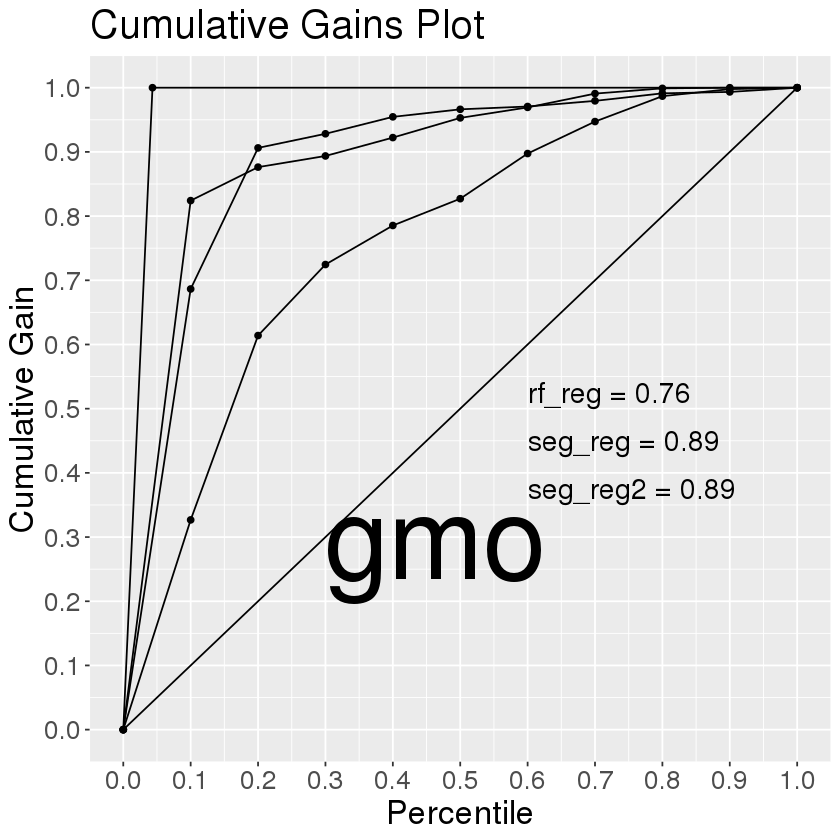

In [63]:
plot_multigains_reg <- plot_multigains(
    lift_df_list=list(
        rf_reg = lift_df_ranger_03_reg,
        seg_reg = lift_df_seg_glm_expiry_exptest_reg,
        seg_reg2 = lift_temp),
    auc_list = list(
        rf_reg= calc_auc(lift_df_ranger_03_reg),
        seg_reg= calc_auc(lift_df_seg_glm_expiry_exptest_reg),
        seg_reg2= calc_auc(lift_temp)),
    prop_positive = 0.04334159)
# png(file = "../../data/output/plot_multigains_03_summ4.png",
#     width = 500, height = 375)
plot(plot_multigains_reg + 
      annotate("text", x = .3, y = .3, hjust = 0, label=reg_name, size = 24))
# dev.off()

# Another One!

In [36]:
reg_name='namecheap'

In [37]:
# RF 

# subset data

dim(expiry_train_df_sub)
dim(expiry_test_df_sub)
cat('\n')

expiry_train_df_sub_reg <- expiry_train_df_sub %>% filter(registrar==reg_name)
expiry_test_df_sub_reg <- expiry_test_df_sub %>% filter(registrar==reg_name)


dim(expiry_train_df_sub_reg)
dim(expiry_test_df_sub_reg)
cat('\n')


dim(expiry_train_df_sub_reg)/dim(expiry_train_df_sub)
dim(expiry_test_df_sub_reg)/dim(expiry_test_df_sub)

# train & test RF
ranger_03_reg <- ranger(
    formula         = renewal_status ~ ., 
    data            = expiry_test_df_sub_reg, 
    importance = 'impurity', 
    num.trees       = 1000,
    probability = TRUE,
    mtry            = 3,
    min.node.size   = 10,
    replace = FALSE,
    sample.fraction = .8,
    seed            = 123
)

ranger_predict_03_reg <- predict(ranger_03_reg, 
                          data = expiry_test_df_sub_reg,
                          type="response")$predictions

ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed

ranger_03_pred_df_reg = data.frame("actual" = expiry_test_df_sub_reg$renewal_status,
          "predicted" = ranger_predict_03_reg)

lift_df_ranger_03_reg <- chart_lift(pred_df = ranger_03_pred_df_reg,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_ranger_03_reg <- plot_gains (lift_df_ranger_03_reg) 

auc_ranger_03_reg <- calc_auc(lift_df_ranger_03_reg)

# save(ranger_03_reg, file="../../data/output/ranger_03_reg")
# save(ranger_predict_03_reg, 
#      file="../../data/output/ranger_predict_03_reg")
# saveRDS(lift_df_ranger_03_reg, file.path('../../data/output/',"lift_df_ranger_03_reg"))



[1] 1188250      12

[1] 296797     12

[1] 221470     12

[1] 55117    12

[1] 0.1863833 1.0000000

[1] 0.1857061 1.0000000

In [38]:
# seg_glm

# subset data

dim(seg_glm_expiry_exptest)
cat('\n')

seg_glm_expiry_exptest_reg <-seg_glm_expiry_exptest %>% filter(registrar==reg_name)


dim(seg_glm_expiry_exptest_reg)
cat('\n')


dim(seg_glm_expiry_exptest_reg)/dim(seg_glm_expiry_exptest)



seg_glm_expiry_exptest_pred_df_reg = data.frame("actual" = seg_glm_expiry_exptest_reg$renewal_status,
          "predicted" = seg_glm_expiry_exptest_reg$first_renewal_prediction)

lift_df_seg_glm_expiry_exptest_reg <- chart_lift(pred_df = seg_glm_expiry_exptest_pred_df_reg,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_seg_glm_expiry_exptest_reg <- plot_gains (lift_df_seg_glm_expiry_exptest_reg) 

auc_seg_glm_expiry_exptest_reg<- calc_auc(lift_df_seg_glm_expiry_exptest_reg)


# saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

[1] 296797     40

[1] 55117    40

[1] 0.1857061 1.0000000

In [39]:
prop.table(table(seg_glm_expiry_exptest_reg$renewal_status))


   Renewed Not Renewd 
0.06038064 0.93961936 

In [42]:
prop_positive = prop.table(table(seg_glm_expiry_exptest_reg$renewal_status))[[1]]
prop_positive

[1] 0.06038064

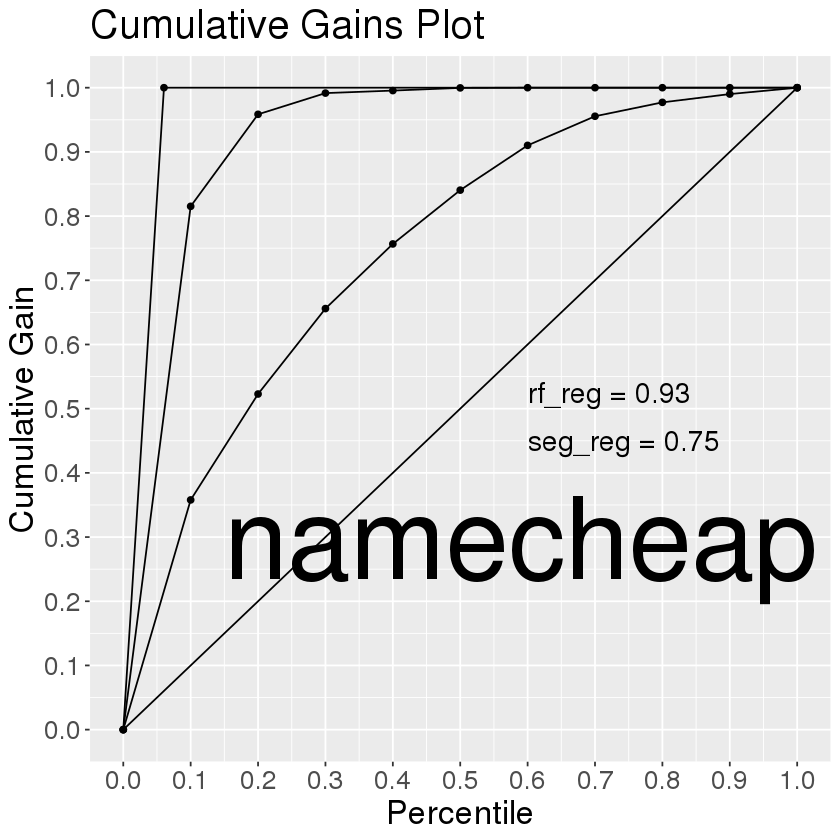

In [45]:
plot_multigains_reg <- plot_multigains(
    lift_df_list=list(
        rf_reg = lift_df_ranger_03_reg,
        seg_reg = lift_df_seg_glm_expiry_exptest_reg),
    auc_list = list(
        rf_reg= calc_auc(lift_df_ranger_03_reg),
        seg_reg= calc_auc(lift_df_seg_glm_expiry_exptest_reg)),
    prop_positive = prop_positive)
# png(file = "../../data/output/plot_multigains_03_summ4.png",
#     width = 500, height = 375)
plot(plot_multigains_reg + 
      annotate("text", x = .15, y = .3, hjust = 0, label=reg_name, size = 24))
# dev.off()

# Uno Mas!

In [46]:
reg_name='alibaba'

In [47]:
# RF 

# subset data

dim(expiry_train_df_sub)
dim(expiry_test_df_sub)
cat('\n')

expiry_train_df_sub_reg <- expiry_train_df_sub %>% filter(registrar==reg_name)
expiry_test_df_sub_reg <- expiry_test_df_sub %>% filter(registrar==reg_name)


dim(expiry_train_df_sub_reg)
dim(expiry_test_df_sub_reg)
cat('\n')


dim(expiry_train_df_sub_reg)/dim(expiry_train_df_sub)
dim(expiry_test_df_sub_reg)/dim(expiry_test_df_sub)

# train & test RF
ranger_03_reg <- ranger(
    formula         = renewal_status ~ ., 
    data            = expiry_test_df_sub_reg, 
    importance = 'impurity', 
    num.trees       = 1000,
    probability = TRUE,
    mtry            = 3,
    min.node.size   = 10,
    replace = FALSE,
    sample.fraction = .8,
    seed            = 123
)

ranger_predict_03_reg <- predict(ranger_03_reg, 
                          data = expiry_test_df_sub_reg,
                          type="response")$predictions

ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed

ranger_03_pred_df_reg = data.frame("actual" = expiry_test_df_sub_reg$renewal_status,
          "predicted" = ranger_predict_03_reg)

lift_df_ranger_03_reg <- chart_lift(pred_df = ranger_03_pred_df_reg,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_ranger_03_reg <- plot_gains (lift_df_ranger_03_reg) 

auc_ranger_03_reg <- calc_auc(lift_df_ranger_03_reg)

# save(ranger_03_reg, file="../../data/output/ranger_03_reg")
# save(ranger_predict_03_reg, 
#      file="../../data/output/ranger_predict_03_reg")
# saveRDS(lift_df_ranger_03_reg, file.path('../../data/output/',"lift_df_ranger_03_reg"))



[1] 1188250      12

[1] 296797     12

[1] 123060     12

[1] 30567    12

[1] 0.1035641 1.0000000

[1] 0.1029896 1.0000000

In [48]:
# seg_glm

# subset data

dim(seg_glm_expiry_exptest)
cat('\n')

seg_glm_expiry_exptest_reg <-seg_glm_expiry_exptest %>% filter(registrar==reg_name)


dim(seg_glm_expiry_exptest_reg)
cat('\n')


dim(seg_glm_expiry_exptest_reg)/dim(seg_glm_expiry_exptest)



seg_glm_expiry_exptest_pred_df_reg = data.frame("actual" = seg_glm_expiry_exptest_reg$renewal_status,
          "predicted" = seg_glm_expiry_exptest_reg$first_renewal_prediction)

lift_df_seg_glm_expiry_exptest_reg <- chart_lift(pred_df = seg_glm_expiry_exptest_pred_df_reg,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_seg_glm_expiry_exptest_reg <- plot_gains (lift_df_seg_glm_expiry_exptest_reg) 

auc_seg_glm_expiry_exptest_reg<- calc_auc(lift_df_seg_glm_expiry_exptest_reg)


# saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

[1] 296797     40

[1] 30567    40

[1] 0.1029896 1.0000000

In [49]:
prop.table(table(seg_glm_expiry_exptest_reg$renewal_status))


   Renewed Not Renewd 
 0.0341872  0.9658128 

In [50]:
prop_positive = prop.table(table(seg_glm_expiry_exptest_reg$renewal_status))[[1]]
prop_positive

[1] 0.0341872

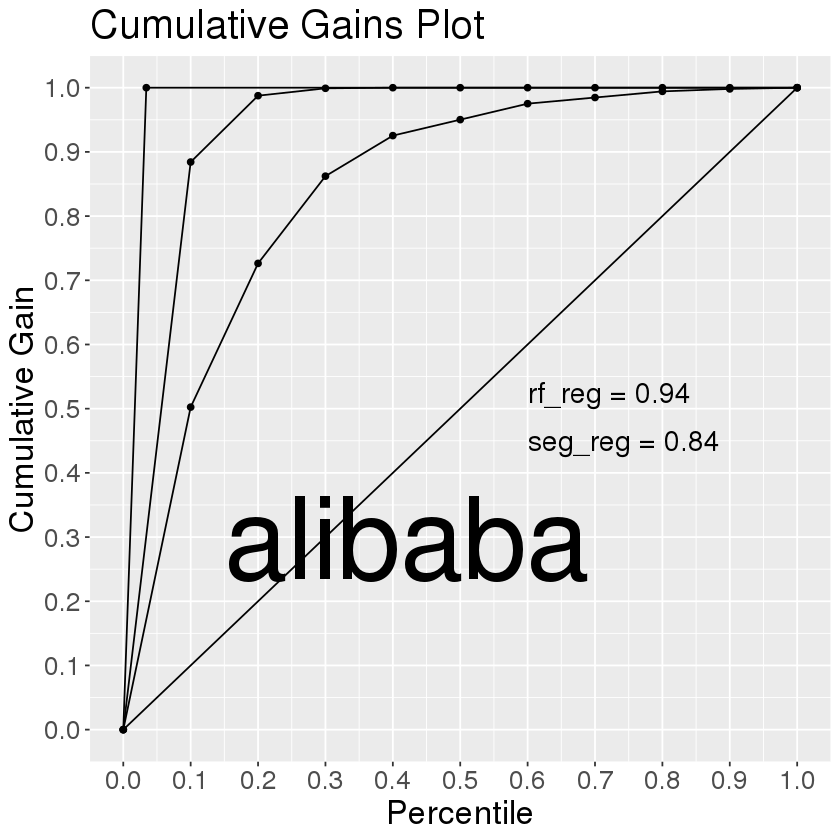

In [51]:
plot_multigains_reg <- plot_multigains(
    lift_df_list=list(
        rf_reg = lift_df_ranger_03_reg,
        seg_reg = lift_df_seg_glm_expiry_exptest_reg),
    auc_list = list(
        rf_reg= calc_auc(lift_df_ranger_03_reg),
        seg_reg= calc_auc(lift_df_seg_glm_expiry_exptest_reg)),
    prop_positive = prop_positive)
# png(file = "../../data/output/plot_multigains_03_summ4.png",
#     width = 500, height = 375)
plot(plot_multigains_reg + 
      annotate("text", x = .15, y = .3, hjust = 0, label=reg_name, size = 24))
# dev.off()

# And then? No and then!

In [52]:
reg_name='go daddy'

In [53]:
# RF 

# subset data

dim(expiry_train_df_sub)
dim(expiry_test_df_sub)
cat('\n')

expiry_train_df_sub_reg <- expiry_train_df_sub %>% filter(registrar==reg_name)
expiry_test_df_sub_reg <- expiry_test_df_sub %>% filter(registrar==reg_name)


dim(expiry_train_df_sub_reg)
dim(expiry_test_df_sub_reg)
cat('\n')


dim(expiry_train_df_sub_reg)/dim(expiry_train_df_sub)
dim(expiry_test_df_sub_reg)/dim(expiry_test_df_sub)

# train & test RF
ranger_03_reg <- ranger(
    formula         = renewal_status ~ ., 
    data            = expiry_test_df_sub_reg, 
    importance = 'impurity', 
    num.trees       = 1000,
    probability = TRUE,
    mtry            = 3,
    min.node.size   = 10,
    replace = FALSE,
    sample.fraction = .8,
    seed            = 123
)

ranger_predict_03_reg <- predict(ranger_03_reg, 
                          data = expiry_test_df_sub_reg,
                          type="response")$predictions

ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed

ranger_03_pred_df_reg = data.frame("actual" = expiry_test_df_sub_reg$renewal_status,
          "predicted" = ranger_predict_03_reg)

lift_df_ranger_03_reg <- chart_lift(pred_df = ranger_03_pred_df_reg,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_ranger_03_reg <- plot_gains (lift_df_ranger_03_reg) 

auc_ranger_03_reg <- calc_auc(lift_df_ranger_03_reg)

# save(ranger_03_reg, file="../../data/output/ranger_03_reg")
# save(ranger_predict_03_reg, 
#      file="../../data/output/ranger_predict_03_reg")
# saveRDS(lift_df_ranger_03_reg, file.path('../../data/output/',"lift_df_ranger_03_reg"))



[1] 1188250      12

[1] 296797     12

[1] 108988     12

[1] 27537    12

[1] 0.09172144 1.00000000

[1] 0.09278059 1.00000000

In [62]:
head(expiry_test_df_sub_reg)

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>
Renewed,fun,go daddy,United States,Non China,3,l,7,1,7.66,1,10.83
Not Renewd,fun,go daddy,United States,Non China,2,l,14,1,3.74,1,8.75
Not Renewd,fun,go daddy,United States,Non China,2,l,8,1,7.77,1,8.75
Renewed,fun,go daddy,United States,Non China,2,l,13,1,5.42,1,8.00
Renewed,fun,go daddy,United States,Non China,2,l,6,1,5.32,1,8.00
Renewed,fun,go daddy,United States,Non China,2,ln,7,2,2.87,1,8.00


In [63]:
expiry_test_df_sub_reg$renewal_prediction <- ranger_predict_03_reg
head(expiry_test_df_sub_reg)

renewal_status,tld,registrar,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt,renewal_prediction
<fct>,<fct>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>
Renewed,fun,go daddy,United States,Non China,3,l,7,1,7.66,1,10.83,0.6977748
Not Renewd,fun,go daddy,United States,Non China,2,l,14,1,3.74,1,8.75,0.3439872
Not Renewd,fun,go daddy,United States,Non China,2,l,8,1,7.77,1,8.75,0.4405030
Renewed,fun,go daddy,United States,Non China,2,l,13,1,5.42,1,8.00,0.4853910
Renewed,fun,go daddy,United States,Non China,2,l,6,1,5.32,1,8.00,0.6288842
Renewed,fun,go daddy,United States,Non China,2,ln,7,2,2.87,1,8.00,0.7380156


In [54]:
# seg_glm

# subset data

dim(seg_glm_expiry_exptest)
cat('\n')

seg_glm_expiry_exptest_reg <-seg_glm_expiry_exptest %>% filter(registrar==reg_name)


dim(seg_glm_expiry_exptest_reg)
cat('\n')


dim(seg_glm_expiry_exptest_reg)/dim(seg_glm_expiry_exptest)



seg_glm_expiry_exptest_pred_df_reg = data.frame("actual" = seg_glm_expiry_exptest_reg$renewal_status,
          "predicted" = seg_glm_expiry_exptest_reg$first_renewal_prediction)

lift_df_seg_glm_expiry_exptest_reg <- chart_lift(pred_df = seg_glm_expiry_exptest_pred_df_reg,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_seg_glm_expiry_exptest_reg <- plot_gains (lift_df_seg_glm_expiry_exptest_reg) 

auc_seg_glm_expiry_exptest_reg<- calc_auc(lift_df_seg_glm_expiry_exptest_reg)


# saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/output/',"lift_df_seg_glm_expiry_exptest"))

[1] 296797     40

[1] 27537    40

[1] 0.09278059 1.00000000

In [55]:
prop.table(table(seg_glm_expiry_exptest_reg$renewal_status))


   Renewed Not Renewd 
 0.1465301  0.8534699 

In [56]:
prop_positive = prop.table(table(seg_glm_expiry_exptest_reg$renewal_status))[[1]]
prop_positive

[1] 0.1465301

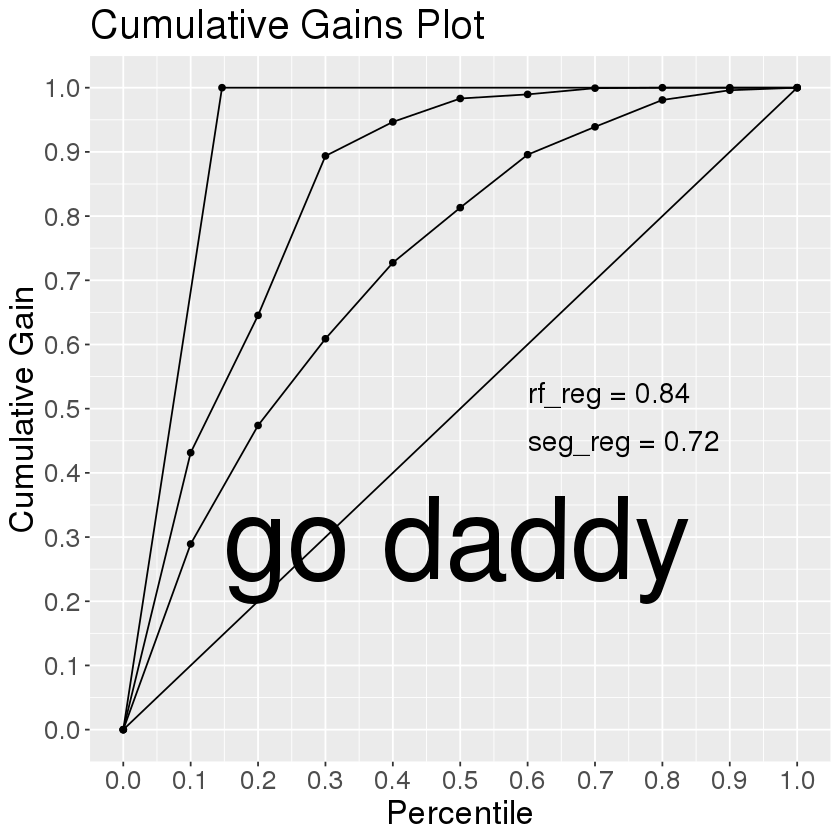

In [57]:
plot_multigains_reg <- plot_multigains(
    lift_df_list=list(
        rf_reg = lift_df_ranger_03_reg,
        seg_reg = lift_df_seg_glm_expiry_exptest_reg),
    auc_list = list(
        rf_reg= calc_auc(lift_df_ranger_03_reg),
        seg_reg= calc_auc(lift_df_seg_glm_expiry_exptest_reg)),
    prop_positive = prop_positive)
# png(file = "../../data/output/plot_multigains_03_summ4.png",
#     width = 500, height = 375)
plot(plot_multigains_reg + 
      annotate("text", x = .15, y = .3, hjust = 0, label=reg_name, size = 24))
# dev.off()

# Prototype Aggregate Segmented RF script
inputs: list of registrar segments, number of trees, parameters, train, test
script will train & test separate forest for each registrar in list and one aggregate forest for the rest of the data

In [60]:
temp <- joint_pred_df[c("reg","obs_count_s","na_count_s","tpr_0.5_s","tpr_0.5_r","aucpr_s","aucpr_r","aucpr_srrat")] %>% arrange(desc(obs_count_s))
temp$reg

[1] namecheap                  gmo                       
  [3] alibaba                    go daddy                  
  [5] pdr ltd                    reg.ru                    
  [7] chengdu west               gandi sas                 
  [9] hostinger                  zhengzhou century connect 
 [11] uniregistrar               onlinenic                 
 [13] tucows                     fbs                       
 [15] dynadot                    network solutions         
 [17] url solutions              enom                      
 [19] 1&1 internet               ovh                       
 [21] realtime register          key-systems               
 [23] namesilo                   beget                     
 [25] dotserve inc               west263 international     
 [27] hosting ukraine            domain.com - registrar    
 [29] ru-center                  hosting concepts          
 [31] nics telekom               cronon ag                 
 [33] google                     name.com                  
 [35] soluciones corporativas    shanghai meicheng         
 [37] xin net                    eranet                    
 [39] ascio                      gabia                     
 [41] united domains             global domains            
 [43] web commerce comm          porkbun                   
 [45] mesh digital               tld registrar solns       
 [47] automattic                 jogjacamp                 
 [49] rumahweb                   mat bao                   
 [51] alibaba sg                 ligne web services        
 [53] p.a viet nam               euro dns                  
 [55] bizcn                      metaregistrar             
 [57] csl                        instra corporation        
 [59] crazy domains              1api                      
 [61] gransy                     10dencehispahard          
 [63] internetx                  diamatrix                 
 [65] shanghai best oray         xiamen chinasource        
 [67] dotname korea              liquidnet                 
 [69] nicenic                    nhan hoa software         
 [71] register.com               wild west                 
 [73] chengdu fly                ledl.net                  
 [75] promo people               netowl                    
 [77] domeneshop                 netim                     
 [79] registrator domenov        epik llc                  
 [81] 22net inc                  paragon internet          
 [83] zhengzhou zitian           epag                      
 [85] markmonitor                dinahosting               
 [87] 101 domain                 atak                      
 [89] xiamen nawang              vautron                   
 [91] web4africa                 csc corporate             
 [93] internetworx ltd           registrygate              
 [95] webnames                   ab name isp               
 [97] online sas                 marcaria.com              
 [99] melbourne it               super registry            
[101] corehub                    synergy wholesale         
[103] nameshield                 com laude                 
[105] ejee group                 domaininfo                
[107] foshan yidong              opentld b.v.              
[109] xiamen 35.com              freeparking               
[111] todaynic                   brandma                   
[113] c-soft oy                  evoplus ltd               
[115] planet hoster              blacknight                
[117] domaindiscover.com         internet gmbh             
[119] variomedia                 alpnames                  
[121] bb online                  cps-datensysteme          
[123] mijn internet              netearth one              
[125] netistrar                  safenames ltd             
[127] server plan                tecnocratica centro       
[129] beijing guoxu              dnc holdings              
[131] domain the net             ename tech                
[133] entorno digital            inames   

In [72]:

seg_rf <- function (reg_list = c('namecheap', 'gmo', 'alibaba', 'go daddy'),
                    num_trees = 5,
                    train = expiry_train_df_sub,
                    test = expiry_test_df_sub) { 
    


    li = list() 
    for (reg_name in reg_list){
        cat("Training & Testing ",reg_name," forest.\n\n")
        train_reg <- train %>% filter(registrar==reg_name)
        test_reg <- test %>% filter(registrar==reg_name)

        ranger_03_reg <- ranger(
        formula         = renewal_status ~ ., 
        data            = train_reg, 
        importance      = 'impurity', 
        num.trees       = num_trees,
        probability     = TRUE,
        mtry            = 3,
        min.node.size   = 10,
        replace         = FALSE,
        sample.fraction = .8,
        seed            = 123
        )

        ranger_predict_03_reg <- predict(ranger_03_reg, 
                                         data = test_reg,
                                         type="response")$predictions
        ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed

        test_reg$renewal_prediction <- ranger_predict_03_reg

        li[[reg_name]] = test_reg
    }

    cat("Training & Testing remaining aggregate forest.")
    train_reg <- train %>% filter(!(registrar %in% reg_list))
    test_reg <- test %>% filter(!(registrar %in% reg_list))

    ranger_03_reg <- ranger(
    formula         = renewal_status ~ ., 
    data            = train_reg, 
    importance      = 'impurity', 
    num.trees       = num_trees,
    probability     = TRUE,
    mtry            = 3,
    min.node.size   = 10,
    replace         = FALSE,
    sample.fraction = .8,
    seed            = 123
    )

    ranger_predict_03_reg <- predict(ranger_03_reg, 
                                     data = test_reg,
                                     type="response")$predictions

    ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed

    test_reg$renewal_prediction <- ranger_predict_03_reg

    li[['Other']] = test_reg
    
    test_results = rbindlist(li)
    
    return(test_results)
    }

write.csv("../../data/output/seg_rf_results.csv")



# save(ranger_03_reg, file="../../data/output/ranger_03_reg")
# save(ranger_predict_03_reg, 
#      file="../../data/output/ranger_predict_03_reg")
# saveRDS(lift_df_ranger_03_reg, file.path('../../data/output/',"lift_df_ranger_03_reg"))



Training & Testing  namecheap  forest.Training & Testing  gmo  forest.Training & Testing  alibaba  forest.Training & Testing  go daddy  forest.Training & Testing remaining aggregate forest.

In [73]:
test_results = rbindlist(li)


In [74]:
dim(test_results)

[1] 296797     13

In [75]:
dim(expiry_test_df_sub)

[1] 296797     12

# Running full scope

In [4]:
reg_list = c('namecheap', 'gmo', 'alibaba', 'go daddy') 
num_trees = 1000
train = expiry_train_df_sub
test = expiry_test_df_sub

In [5]:
li = list() 
for (reg_name in reg_list){
    cat("\nTraining & Testing ",reg_name," forest.\n")
    train_reg <- train %>% filter(registrar==reg_name)
    test_reg <- test %>% filter(registrar==reg_name)

    ranger_03_reg <- ranger(
    formula         = renewal_status ~ ., 
    data            = train_reg, 
    importance      = 'impurity', 
    num.trees       = num_trees,
    probability     = TRUE,
#         mtry            = 3,
#         min.node.size   = 10,
#         replace         = FALSE,
#         sample.fraction = .8,
    seed            = 123
    )

    ranger_predict_03_reg <- predict(ranger_03_reg, 
                                     data = test_reg,
                                     type="response")$predictions
    ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed

    test_reg$renewal_prediction <- ranger_predict_03_reg

    li[[reg_name]] = test_reg
}


Training & Testing  namecheap  forest.
Growing trees.. Progress: 69%. Estimated remaining time: 13 seconds.

Training & Testing  gmo  forest.

Training & Testing  alibaba  forest.

Training & Testing  go daddy  forest.


In [6]:
length(li)

[1] 4

In [8]:
sapply(li, dim)

namecheap,gmo,alibaba,go daddy
55117,31494,30567,27537
13,13,13,13


In [17]:
cat("\nTraining & Testing remaining aggregate forest.\n")
train_reg <- train %>% filter(!(registrar %in% reg_list))
test_reg <- test %>% filter(!(registrar %in% reg_list))

ranger_03_reg <- ranger(
formula         = renewal_status ~ ., 
data            = train_reg, 
importance      = 'impurity', 
num.trees       = num_trees,
    probability     = TRUE,
#     mtry            = 3,
#     min.node.size   = 10,
#     replace         = FALSE,
#     sample.fraction = .8,
seed            = 123
)

ranger_predict_03_reg <- predict(ranger_03_reg, 
                                 data = test_reg,
                                 type="response")$predictions

ranger_predict_03_reg <- as.data.frame(ranger_predict_03_reg)$Renewed


Training & Testing remaining aggregate forest.
Growing trees.. Progress: 16%. Estimated remaining time: 2 minutes, 40 seconds.
Growing trees.. Progress: 33%. Estimated remaining time: 2 minutes, 4 seconds.
Growing trees.. Progress: 51%. Estimated remaining time: 1 minute, 29 seconds.
Growing trees.. Progress: 68%. Estimated remaining time: 57 seconds.
Growing trees.. Progress: 85%. Estimated remaining time: 26 seconds.


In [19]:
test_reg$renewal_prediction <- ranger_predict_03_reg

In [20]:
li[['Other']] = test_reg

In [21]:
test_results = rbindlist(li, fill=TRUE)


In [30]:
names(li)

[1] "namecheap" "gmo"       "alibaba"   "go daddy"  "Other"

# Evaluate Aggregate Seg_RF

In [22]:

seg_rf_pred_df_reg = data.frame("actual" = test_results$renewal_status,
          "predicted" = test_results$renewal_prediction)

lift_df_seg_rf <- chart_lift(pred_df = seg_rf_pred_df_reg,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_seg_rf <- plot_gains (lift_df_seg_rf) 

auc_seg_rf <- calc_auc(lift_df_seg_rf)


In [28]:
auc_seg_rf

[1] 0.7740803

In [29]:
lift_df_seg_rf

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,10689,0.3936292,3.936292
0.2,15622,0.5752900,2.876450
0.3,18936,0.6973301,2.324434
0.4,21644,0.7970539,1.992635
0.5,23733,0.8739827,1.747965
0.6,25423,0.9362180,1.560363
0.7,26493,0.9756214,1.393745
0.8,26956,0.9926717,1.240840
0.9,27128,0.9990057,1.110006


In [39]:
for (list_element in names(li)){
    cat(list_element)
    cat('\n')
    print(chart_lift(pred_df =  data.frame("actual" = li[[list_element]]$renewal_status,
          "predicted" = li[[list_element]]$renewal_prediction),
                        dep_var = "actual",
                        pred_var = "predicted"))
    cat('\n')
}


namecheap
     P actu_renwd2      gain     lift
1  0.1        1120 0.3365385 3.365385
2  0.2        1619 0.4864784 2.432392
3  0.3        2003 0.6018630 2.006210
4  0.4        2334 0.7013221 1.753305
5  0.5        2628 0.7896635 1.579327
6  0.6        2866 0.8611779 1.435296
7  0.7        3050 0.9164663 1.309238
8  0.8        3190 0.9585337 1.198167
9  0.9        3285 0.9870793 1.096755
10 1.0        3328 1.0000000 1.000000

gmo
     P actu_renwd2      gain     lift
1  0.1         567 0.4153846 4.153846
2  0.2         891 0.6527473 3.263736
3  0.3        1023 0.7494505 2.498168
4  0.4        1095 0.8021978 2.005495
5  0.5        1159 0.8490842 1.698168
6  0.6        1239 0.9076923 1.512821
7  0.7        1296 0.9494505 1.356358
8  0.8        1347 0.9868132 1.233516
9  0.9        1362 0.9978022 1.108669
10 1.0        1365 1.0000000 1.000000

alibaba
     P actu_renwd2      gain     lift
1  0.1         533 0.5100478 5.100478
2  0.2         803 0.7684211 3.842105
3  0.3         930 0.88995

In [25]:
# seg_glm_expiry_exptest <- readRDS("../../data/seg_glm_expiry_exptest")

seg_glm_expiry_exptest_pred_df = data.frame("actual" = expiry_test_df_sub$renewal_status,
          "predicted" = seg_glm_expiry_exptest$first_renewal_prediction)

lift_df_seg_glm_expiry_exptest <- chart_lift(pred_df = seg_glm_expiry_exptest_pred_df,
                        dep_var = "actual",
                        pred_var = "predicted")

gains_plot_seg_glm_expiry_exptest <- plot_gains (lift_df_seg_glm_expiry_exptest) 

auc_seg_glm_expiry_exptest<- calc_auc(lift_df_seg_glm_expiry_exptest)

In [26]:
plot_multigains_03_summ5 <- plot_multigains(
    lift_df_list=list(
        seg_rf = lift_df_seg_rf,
        seg_lm = lift_df_seg_glm_expiry_exptest),
    auc_list = list(
        seg_rf= calc_auc(lift_df_seg_rf),
        seg_lm= calc_auc(lift_df_seg_glm_expiry_exptest)))
png(file = "../../data/output/plot_multigains_03_summ5.png",
    width = 500, height = 375)
plot(plot_multigains_03_summ5)
dev.off()

png 
  2

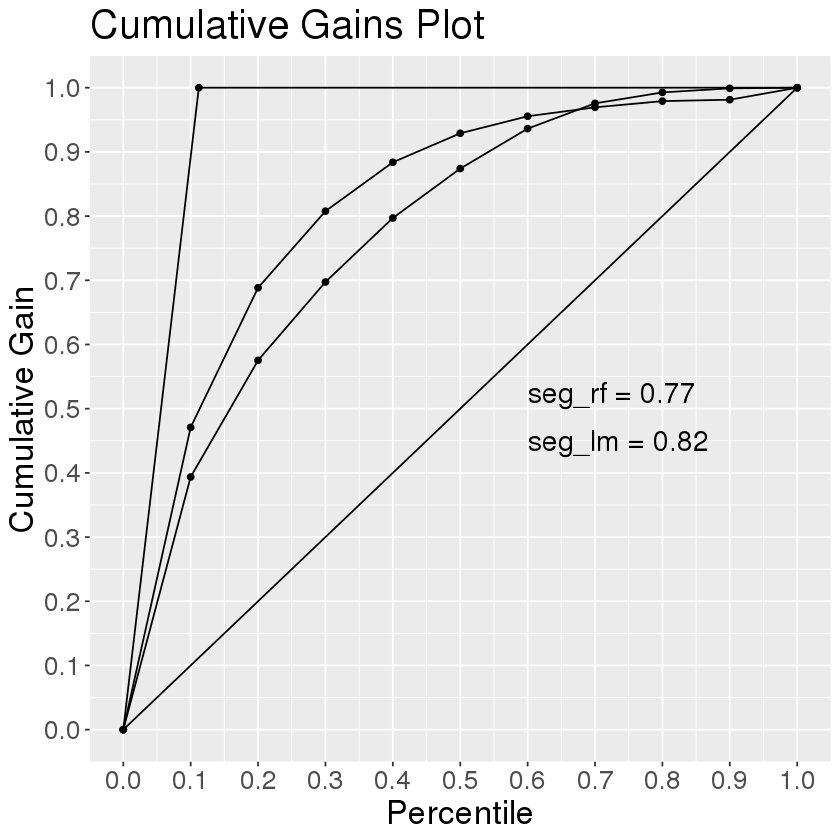

In [27]:
plot_multigains_03_summ5

In [42]:
write.csv(test_results, "../../data/output/seg_rf_results.csv")
save(li, file="../../data/output/li")

system("gsutil cp /home/jupyter/local/Domains_202003/data/output/* gs://data_outputt/output/ ")
system("mv /home/jupyter/local/Domains_202003/data/output/* /home/jupyter/local/Domains_202003/data/")
